In [5]:
import matplotlib.pyplot as plt
import numpy as np

import pickle

import json

from matplotlib.pyplot import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects


In [7]:
paths = [path_effects.Stroke(linewidth=2, foreground='k'), path_effects.Normal()]
plt.ion()

#----------------------------------------------------------------
# Load the magic EDGE colourmap:
with open("../data/EDGE_cmap.json", "r") as f:
  EDGE_cmap = LinearSegmentedColormap("../data//EDGE_cmap.json", json.load(f))

target_sims = np.repeat(['Halo605_fiducial_hires', 'Halo600_fiducial_hires'], 3)
target_index = np.repeat([9, 1], 3)

GC_tforms = np.repeat([747.820854890386, 1354.647227], 3)

titles = ['Regular Star Formation','Triggered Formation']



In [8]:
#---------------------------------------------------------------------------
# Initialise figure instance:
#---------------------------------------------------------------------------

fontsize = 10
lw = 1.5
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.labelsize'] = fontsize - 2
plt.rcParams['ytick.labelsize'] = fontsize - 2
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['xtick.minor.width'] = lw * (2/3.)
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['ytick.minor.width'] = lw * (2/3.)
plt.rcParams['legend.fontsize'] = fontsize - 2

row_gap = 0.05


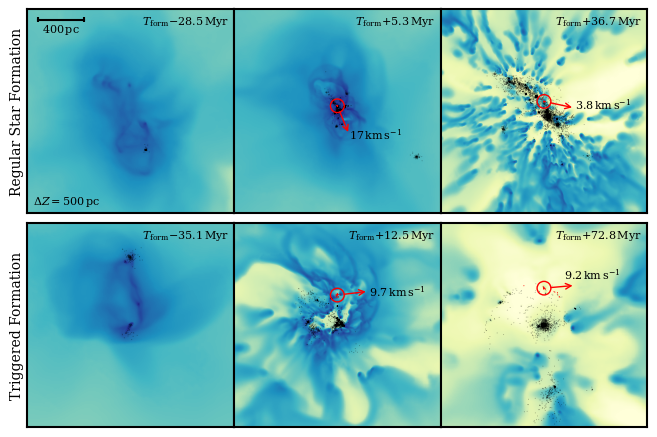

In [16]:
fig, ax = plt.subplots(figsize=(8, 8*2/3. + 8*2/3.*row_gap*1/3.), nrows=2, ncols=3, gridspec_kw={'hspace':row_gap, 'wspace':0.0})
#---------------------------------------------------------------------------
# Loop over each panel:
#---------------------------------------------------------------------------
text_c = 'black'
star_c = 'black'
GC_c = 'red'

target_snaps = [18,19,20, 28,29,30]
c_range = (2e2, 1e9)

width = 1800 # [pc]
slice_width = 500 # [pc]
for axis_index,(axes, sim, i, snap, GC_tform) in enumerate(zip(np.ravel(ax), target_sims, target_index, target_snaps, GC_tforms)):

  # Load the saved data:
  img = np.load('../data/%s_%i_delta%i_snap%i_gas_density_image.npy' % (sim, i, slice_width, snap))
  filename = '../data/GCplot_delta%i_dict.pk1' % slice_width
  with open(filename, 'rb') as file:
    props = pickle.load(file)

  extent = np.array([-1,1,-1,1]) * width/2.
  img_plot = axes.imshow(img, origin='lower', extent=extent, cmap=cm.YlGnBu, norm=LogNorm())
  img_plot.set_clim(*c_range)

  GC = props[sim][i][snap]['GC_stars']
  pos = props[sim][i][snap]['pos']
  GC_pos = props[sim][i][snap]['GC_pos']
  GC_vel = props[sim][i][snap]['GC_vel']

  axes.scatter(pos[~GC,0], pos[~GC,1], color=star_c, s=0.5, edgecolors='none', alpha=0.3)
  axes.scatter(pos[GC,0], pos[GC,1], color='red', s=0.5, edgecolors='none', alpha=1.0)

  axes.set_xlim(*extent[[0,1]])
  axes.set_ylim(*extent[[2,3]])
  axes.set_facecolor('black')
  axes.set_xticks([])
  axes.set_yticks([])
  axes.set_aspect('auto')

  # Add annotation for the GC:
  ring_width = 100 * (1800/1500)
  arrow_length = 250
  ring = patches.Circle(GC_pos[[0,1]], radius=ring_width/2., facecolor='None', edgecolor=GC_c, lw=1)
  axes.add_artist(ring)
  unit_vector = GC_vel / np.linalg.norm(GC_vel)
  delta_v = np.array(GC_pos[[0,1]]) + np.array(unit_vector[[0,1]])*arrow_length
  new_GC_pos = [np.interp(ring_width/2., np.array([0, arrow_length]), np.array([GC_pos[[0, 1]], delta_v])[:, i]) for i in [0,1]]

  arrow = axes.annotate(None, xytext=delta_v, xy=new_GC_pos, arrowprops=dict(arrowstyle='<-', color=GC_c, lw=1, shrinkA=0, shrinkB=0))
  delta_v = np.array(GC_pos[[0,1]]) + np.array(unit_vector[[0,1]])*(arrow_length*1.1)


  if axis_index == 2:
    axes.annotate(r'$%.2g\,\rm{km}\,\rm{s}^{-1}$' % np.linalg.norm(GC_vel), xytext=[268.78748295 , 65], xy=new_GC_pos, arrowprops=dict(arrowstyle='-', linewidth=0), color='black', fontsize=fontsize-2, ha='left', va='center')
  elif axis_index == 5:
    axes.annotate(r'$%.2g\,\rm{km}\,\rm{s}^{-1}$' % np.linalg.norm(GC_vel), xytext=[175.88009302 ,450.80431746], xy=new_GC_pos, arrowprops=dict(arrowstyle='-', linewidth=0), color='black', fontsize=fontsize-2, ha='left', va='center')
  else:
    axes.annotate(r'$%.2g\,\rm{km}\,\rm{s}^{-1}$' % np.linalg.norm(GC_vel), xytext=delta_v, xy=new_GC_pos, arrowprops=dict(arrowstyle='-', linewidth=0), color='black', fontsize=fontsize-2, ha='left', va='center')

  relative_time = props[sim][i][snap]['time'] - GC_tform
  if np.sign(relative_time) >= 0:
    sign = '+'
  else:
    sign = '-'
  string = r'$T_{\rm{form}}\rm{%s}%.1f\,\rm{Myr}$' % (sign, np.abs(relative_time))
  axes.text(0.975, 0.975, string, va='top', ha='right', fontsize=fontsize-2, color=text_c, transform=axes.transAxes)
#---------------------------------------------------------------------------

# Misc designs:
#---------------------------------------------------------------------------
# Add row labels:
for i, title in enumerate(titles):
  ax[i,0].text(-0.05, 0.5, title, ha='center', va='center', fontsize=fontsize, rotation=90, transform=ax[i,0].transAxes)

# Distance bar labels:
ruler = int('%.0f' % float('%.1g' % (width/5)))
corner1 = width/2. - (0.1*width/2.) - ruler
corner2 = 0.9*width/2.
corner1 = 0.1*width/2. - width/2.
cap = 0.025 * width/2.
for lw, color, order, capstyle in zip([1.5], ['k'], [100], ['butt']):
  _, _, caps = ax[0,0].errorbar([corner1, corner1+ruler], np.ones(2)*corner2, yerr=np.ones(2)*cap, \
                                color=color, linewidth=lw, ecolor=color, elinewidth=lw, zorder=order)
  caps[0].set_capstyle(capstyle)
ax[0,0].text(corner1 + ruler/2., corner2 - 0.025*width/2.,  r'$%.0f\,$pc' % ruler, \
             va='top', ha='center', color=text_c, fontsize=fontsize-2)

# Add delta:
ax[0,0].text(0.025, 0.025, r'$\Delta Z=%i\,$pc' % (slice_width), va='bottom', ha='left', color=text_c, \
             fontsize=fontsize-2, transform=ax[0,0].transAxes)
#---------------------------------------------------------------------------


plt.savefig('../Figures/Fig3.pdf', bbox_inches='tight')
plt.savefig('../Figures/Fig3.png', bbox_inches='tight',dpi=750)
